In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("all_data.csv")

drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","Total_lines"
]

def show_correlation_matrix(dataframe, taille_figure=(6, 4), cmap="coolwarm"):
    plt.figure(figsize=taille_figure)
    sns.heatmap(dataframe.corr(), cmap=cmap, center=0)
    plt.title("Correlation matrix")
    plt.show()

def show_target_correlation(df, variable="SOG", taille_figure=(6, 4)):
    corr_with_vmg = df.corr()[variable].sort_values(ascending=False)
    #print(f"Correlation with {variable} :")
    # print(corr_with_vmg)
    
    plt.figure(figsize=taille_figure)
    sns.heatmap(corr_with_vmg.to_frame(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation with {variable}")
    plt.show()

def compute_anova(df, target="SOG"):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)
    df_no_missing = df_copy.dropna(subset=cols)
    formula_no_missing = f"{target} ~ " + " + ".join(
        list(df_no_missing.columns.drop(target)))
    model_no_missing = smf.ols(formula=formula_no_missing, data=df_no_missing).fit()
    anova_no_missing = sm.stats.anova_lm(model_no_missing, typ=2)
    return anova_no_missing.sort_values("F", ascending=False)

def linear_regression(df, target="SOG", degree=1, top_coefs=30):
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)

    df_clean = df_copy.dropna(subset=cols)
    if df_clean[target].isna().any():
        df_clean = df_clean.dropna(subset=[target])

    X = df_clean[cols]
    y = df_clean[target]

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)

    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )

    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # Affichage de la performance
    print(f"R²: {r2_score(y, y_pred):.3f}")
    print(f"Used samples: {len(X)}")

    # Coefficients
    coefs = model.named_steps['linearregression'].coef_
    intercept = model.named_steps['linearregression'].intercept_

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs
    }).sort_values('coefficient', key=abs, ascending=False)

    # Formule affichée
    print("\n Formula :")
    terms = [f"{coef:.3f} * {feat}" for feat, coef in zip(feature_names, coefs)]
    equation = " +\n  ".join(terms)
    print(f"{target} ≈ {intercept:.3f} +\n  {equation}")

    return coef_df.head(top_coefs)


def t_test(df1, df2, target="SOG"):
    t_stat, p_value = stats.ttest_ind(df1[target].dropna(), df2[target].dropna())
    print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.15f}")
    
    # If p-value is less than 0.05, the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant, keeping data split.")
    else:
        print("The difference is not statistically significant, keeping data combined.")

def full_analysis(df_numeric, target_variable="SOG"):
    # Display the correlation matrix
    # print("Correlation matrix:")
    #show_correlation_matrix(df_numeric)
    
    # Display correlation with the target variable
    print(f"\nCorrelation with {target_variable}:")
    show_target_correlation(df_numeric, variable=target_variable)
    
    # Compute and display ANOVA results
    print("\nANOVA:")
    anova_results = compute_anova(df_numeric)
    display(anova_results)
    
    # Apply and display polynomial regression results
    print("\nPolynomial fit:")
    regression_results = linear_regression(df_numeric)
    display(regression_results)




## I. All together

In [2]:


df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)
df_numeric.dropna(subset=["SOG"], inplace=True)

print(f"Variables utilisées:", df_numeric.columns.tolist())
print(f"Number of rows after filtering: {len(df_numeric)}")


Variables utilisées: ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight']
Number of rows after filtering: 80131



Correlation with SOG:


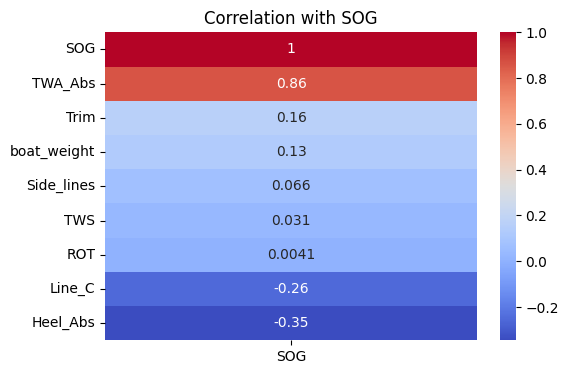


ANOVA:


,sum_sq,df,F,PR(>F)
TWA_Abs,245603.178724,1.0,190941.151809,0.000000e+00
TWS,5470.379232,1.0,4252.878635,0.000000e+00
Side_lines,5242.427423,1.0,4075.660322,0.000000e+00
boat_weight,4486.106411,1.0,3487.667911,0.000000e+00
Line_C,3068.377586,1.0,2385.472181,0.000000e+00
Trim,1295.699388,1.0,1007.325454,1.680344e-219
Heel_Abs,694.461628,1.0,539.900598,5.609672e-119
ROT,65.090666,1.0,50.603933,1.140980e-12
Residual,89958.342388,69937.0,NaN,NaN



Polynomial fit:
R²: 0.797
Used samples: 69946

 Formula :
SOG ≈ 23.994 +
  0.125 * Heel_Abs +
  0.614 * Line_C +
  0.031 * ROT +
  0.795 * Side_lines +
  -0.149 * Trim +
  2.488 * TWA_Abs +
  0.287 * TWS +
  0.280 * boat_weight


,feature,coefficient
5,TWA_Abs,2.488137
3,Side_lines,0.794819
1,Line_C,0.614360
6,TWS,0.286701
7,boat_weight,0.280399
4,Trim,-0.149148
0,Heel_Abs,0.124972
2,ROT,0.030548


In [3]:
full_analysis(df_numeric)

## II Upwind:

### II.1. All upwind data

In [4]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 48787



Correlation with SOG:


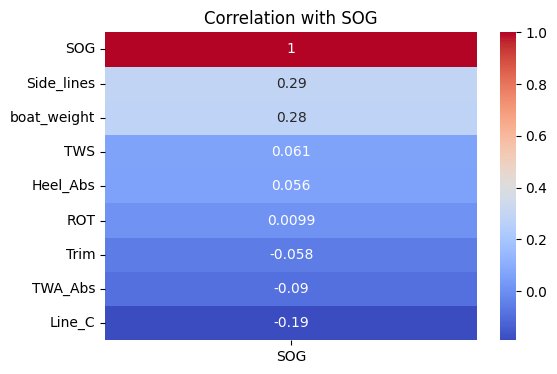


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,2859.476887,1.0,2408.478094,0.000000e+00
Side_lines,2644.230676,1.0,2227.180674,0.000000e+00
Line_C,1393.542980,1.0,1173.752358,8.038926e-254
Trim,543.184839,1.0,457.513328,5.611190e-101
TWS,344.895684,1.0,290.498484,6.325394e-65
Heel_Abs,96.925960,1.0,81.638727,1.699743e-19
TWA_Abs,12.808045,1.0,10.787951,1.022444e-03
ROT,3.962059,1.0,3.337160,6.773834e-02
Residual,51157.616866,43089.0,NaN,NaN



Polynomial fit:
R²: 0.173
Used samples: 43098

 Formula :
SOG ≈ 22.278 +
  0.051 * Heel_Abs +
  0.546 * Line_C +
  0.010 * ROT +
  0.764 * Side_lines +
  -0.117 * Trim +
  -0.019 * TWA_Abs +
  0.097 * TWS +
  0.282 * boat_weight


,feature,coefficient
3,Side_lines,0.763931
1,Line_C,0.546272
7,boat_weight,0.282225
4,Trim,-0.116614
6,TWS,0.096577
0,Heel_Abs,0.050872
5,TWA_Abs,-0.018921
2,ROT,0.009782


In [5]:
full_analysis(df_numeric_upwind)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [6]:
gian_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Gian Stragiotti") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 24390



Correlation with SOG:


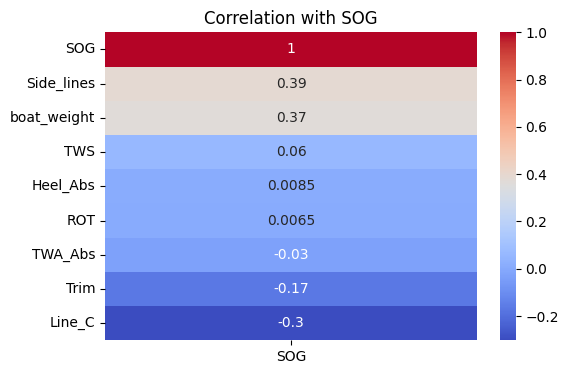


ANOVA:


,sum_sq,df,F,PR(>F)
Side_lines,2548.788780,1.0,2594.069268,0.000000e+00
Line_C,1443.551238,1.0,1469.196637,3.705227e-312
TWS,669.994061,1.0,681.896836,2.866545e-148
Trim,615.034728,1.0,625.961123,2.011325e-136
boat_weight,162.091074,1.0,164.970702,1.230812e-37
TWA_Abs,86.758057,1.0,88.299357,6.105745e-21
ROT,4.515232,1.0,4.595447,3.206687e-02
Heel_Abs,1.561062,1.0,1.588795,2.075105e-01
Residual,23882.711860,24307.0,NaN,NaN



Polynomial fit:
R²: 0.250
Used samples: 24316

 Formula :
SOG ≈ 22.438 +
  -0.009 * Heel_Abs +
  0.811 * Line_C +
  0.014 * ROT +
  1.160 * Side_lines +
  -0.161 * Trim +
  0.066 * TWA_Abs +
  0.207 * TWS +
  0.126 * boat_weight


,feature,coefficient
3,Side_lines,1.160160
1,Line_C,0.810910
6,TWS,0.206524
4,Trim,-0.161363
7,boat_weight,0.126144
5,TWA_Abs,0.066112
2,ROT,0.013892
0,Heel_Abs,-0.008725


In [7]:
full_analysis(df_numeric_gian_upwind)

#### II.2.2. Upwind: Karl

In [8]:
karl_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Karl Maeder") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")

Number of rows after filtering: 24397



Correlation with SOG:


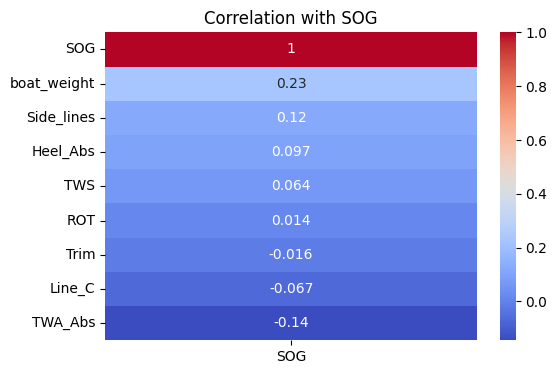


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,1610.307281,1.0,1212.099830,2.076783e-257
TWA_Abs,345.784171,1.0,260.276371,3.676803e-58
Heel_Abs,332.250386,1.0,250.089310,5.706682e-56
Side_lines,322.512750,1.0,242.759661,2.156251e-54
Line_C,252.410822,1.0,189.993002,5.169048e-43
TWS,148.995273,1.0,112.150735,3.924369e-26
Trim,22.705888,1.0,17.091026,3.578501e-05
ROT,0.011136,1.0,0.008382,9.270529e-01
Residual,24940.436284,18773.0,NaN,NaN



Polynomial fit:
R²: 0.129
Used samples: 18782

 Formula :
SOG ≈ 22.072 +
  0.143 * Heel_Abs +
  0.314 * Line_C +
  0.001 * ROT +
  0.358 * Side_lines +
  -0.036 * Trim +
  -0.155 * TWA_Abs +
  0.104 * TWS +
  0.312 * boat_weight


,feature,coefficient
3,Side_lines,0.358322
1,Line_C,0.313521
7,boat_weight,0.312357
5,TWA_Abs,-0.155373
0,Heel_Abs,0.143032
6,TWS,0.103688
4,Trim,-0.035905
2,ROT,0.000789


In [9]:
full_analysis(df_numeric_karl_upwind)

#### II.2.3. Upwind: Karl vs Gian t_test

In [10]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: 31.779, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [11]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 24391



Correlation with SOG:


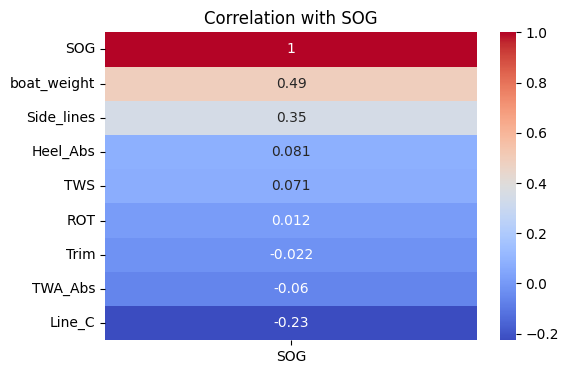


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,5248.607276,1.0,5057.696986,0.000000e+00
Side_lines,1033.068038,1.0,995.491723,1.618992e-213
Line_C,476.714879,1.0,459.375084,7.896866e-101
Trim,216.690251,1.0,208.808465,4.205390e-47
TWA_Abs,203.910997,1.0,196.494038,1.928636e-44
Heel_Abs,107.752591,1.0,103.833251,2.507144e-24
TWS,0.815977,1.0,0.786297,3.752324e-01
ROT,0.003852,1.0,0.003712,9.514190e-01
Residual,21803.053675,21010.0,NaN,NaN



Polynomial fit:
R²: 0.325
Used samples: 21019

 Formula :
SOG ≈ 22.417 +
  0.077 * Heel_Abs +
  0.452 * Line_C +
  0.000 * ROT +
  0.678 * Side_lines +
  -0.106 * Trim +
  -0.110 * TWA_Abs +
  0.007 * TWS +
  0.547 * boat_weight


,feature,coefficient
3,Side_lines,0.677812
7,boat_weight,0.546648
1,Line_C,0.451805
5,TWA_Abs,-0.109731
4,Trim,-0.105868
0,Heel_Abs,0.076679
6,TWS,0.006669
2,ROT,0.000437


In [12]:
full_analysis(df_numeric_master_upwind)

#### II.3.2 Slave

In [13]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 24396



Correlation with SOG:


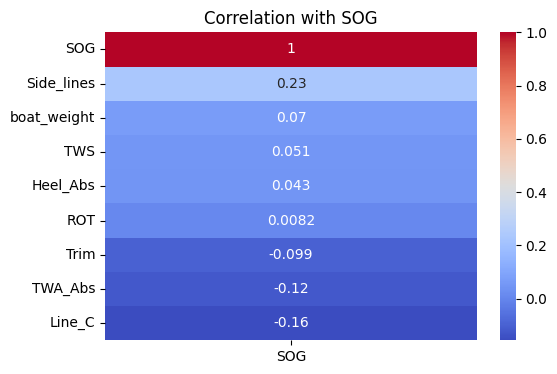


ANOVA:


,sum_sq,df,F,PR(>F)
Side_lines,1553.919666,1.0,1345.147488,6.464811e-286
Line_C,920.703343,1.0,797.005029,2.770934e-172
Trim,239.413954,1.0,207.248216,8.917822e-47
TWS,156.927303,1.0,135.843810,2.666311e-31
TWA_Abs,125.936760,1.0,109.016908,1.844661e-25
boat_weight,9.543496,1.0,8.261308,4.053761e-03
Heel_Abs,5.551537,1.0,4.805677,2.837652e-02
ROT,0.848572,1.0,0.734564,3.914170e-01
Residual,25495.350750,22070.0,NaN,NaN



Polynomial fit:
R²: 0.114
Used samples: 22079

 Formula :
SOG ≈ 22.146 +
  0.017 * Heel_Abs +
  0.629 * Line_C +
  -0.006 * ROT +
  0.827 * Side_lines +
  -0.108 * Trim +
  -0.087 * TWA_Abs +
  0.094 * TWS +
  0.024 * boat_weight


,feature,coefficient
3,Side_lines,0.827105
1,Line_C,0.629078
4,Trim,-0.108125
6,TWS,0.093958
5,TWA_Abs,-0.087288
7,boat_weight,0.024085
0,Heel_Abs,0.017138
2,ROT,-0.006337


In [14]:
full_analysis(df_numeric_slave_upwind)

#### III.3.3. Upwind: Master vs Slave t_test

In [15]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 16.509, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [16]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 31344



Correlation with SOG:


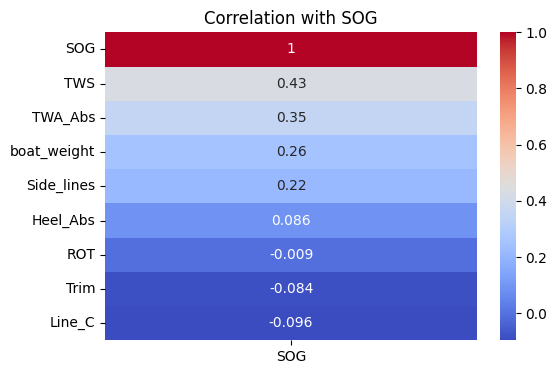


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,4387.953367,1.0,3616.766633,0.000000e+00
TWA_Abs,3186.145007,1.0,2626.177169,0.000000e+00
Side_lines,1733.965140,1.0,1429.219214,9.237669e-305
Line_C,1442.853566,1.0,1189.270759,4.836281e-255
boat_weight,1373.326860,1.0,1131.963434,4.198371e-243
Heel_Abs,471.224623,1.0,388.406473,7.453591e-86
Trim,286.233597,1.0,235.927786,5.109984e-53
ROT,70.149986,1.0,57.821063,2.964633e-14
Residual,32561.758155,26839.0,NaN,NaN



Polynomial fit:
R²: 0.371
Used samples: 26848

 Formula :
SOG ≈ 26.749 +
  0.175 * Heel_Abs +
  0.636 * Line_C +
  -0.053 * ROT +
  0.698 * Side_lines +
  -0.125 * Trim +
  0.411 * TWA_Abs +
  0.476 * TWS +
  0.261 * boat_weight


,feature,coefficient
3,Side_lines,0.698415
1,Line_C,0.635582
6,TWS,0.475566
5,TWA_Abs,0.410776
7,boat_weight,0.260743
0,Heel_Abs,0.175045
4,Trim,-0.124600
2,ROT,-0.052860


In [17]:

full_analysis(df_numeric_downwind)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [18]:
gian_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Gian Stragiotti") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 15667



Correlation with SOG:


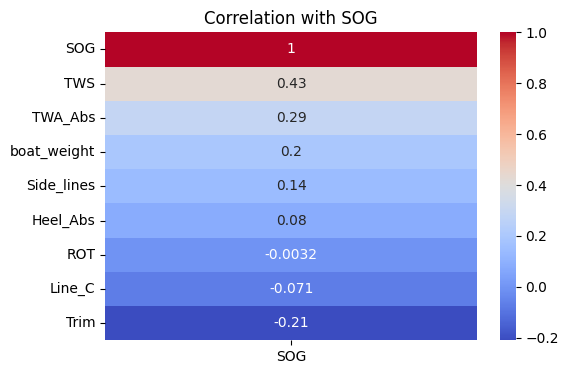


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,4345.499892,1.0,4100.945056,0.000000e+00
Side_lines,1201.351018,1.0,1133.741719,5.406315e-240
TWA_Abs,1127.409729,1.0,1063.961677,7.971268e-226
Trim,558.302069,1.0,526.882100,1.060563e-114
Heel_Abs,503.532878,1.0,475.195195,8.350172e-104
Line_C,472.288849,1.0,445.709508,1.426841e-97
boat_weight,120.891126,1.0,114.087649,1.539829e-26
ROT,4.029179,1.0,3.802426,5.119626e-02
Residual,16535.585062,15605.0,NaN,NaN



Polynomial fit:
R²: 0.381
Used samples: 15614

 Formula :
SOG ≈ 26.918 +
  0.237 * Heel_Abs +
  0.549 * Line_C +
  -0.017 * ROT +
  0.894 * Side_lines +
  -0.226 * Trim +
  0.332 * TWA_Abs +
  0.652 * TWS +
  -0.153 * boat_weight


,feature,coefficient
3,Side_lines,0.893856
6,TWS,0.652132
1,Line_C,0.549181
5,TWA_Abs,0.332324
0,Heel_Abs,0.236512
4,Trim,-0.226478
7,boat_weight,-0.153161
2,ROT,-0.016624


In [19]:

full_analysis(df_numeric_gian_downwind)

#### III.2.2. Downwind: Karl

In [20]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 15677



Correlation with SOG:


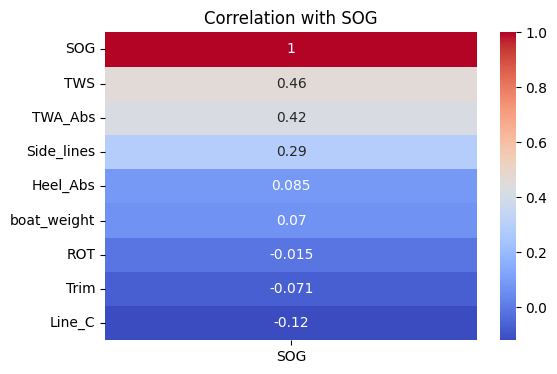


ANOVA:


,sum_sq,df,F,PR(>F)
TWA_Abs,2699.323101,1.0,2123.917116,0.000000e+00
TWS,868.844933,1.0,683.636065,2.466070e-146
boat_weight,862.038029,1.0,678.280167,3.091082e-145
Side_lines,428.750997,1.0,337.355532,2.927242e-74
Line_C,348.888180,1.0,274.516814,6.208678e-61
ROT,95.738982,1.0,75.330613,4.530249e-18
Heel_Abs,57.464354,1.0,45.214864,1.851306e-11
Trim,9.148027,1.0,7.197972,7.309296e-03
Residual,14266.047192,11225.0,NaN,NaN



Polynomial fit:
R²: 0.404
Used samples: 11234

 Formula :
SOG ≈ 26.514 +
  0.095 * Heel_Abs +
  0.426 * Line_C +
  -0.096 * ROT +
  0.459 * Side_lines +
  -0.035 * Trim +
  0.589 * TWA_Abs +
  0.379 * TWS +
  0.296 * boat_weight


,feature,coefficient
5,TWA_Abs,0.588513
3,Side_lines,0.459456
1,Line_C,0.426056
6,TWS,0.378636
7,boat_weight,0.295799
2,ROT,-0.095636
0,Heel_Abs,0.095339
4,Trim,-0.034691


In [21]:
full_analysis(df_numeric_karl_downwind)

#### III.2.3. Downwind: Karl vs Gian t_test

In [22]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -38.976, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [23]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 15670



Correlation with SOG:


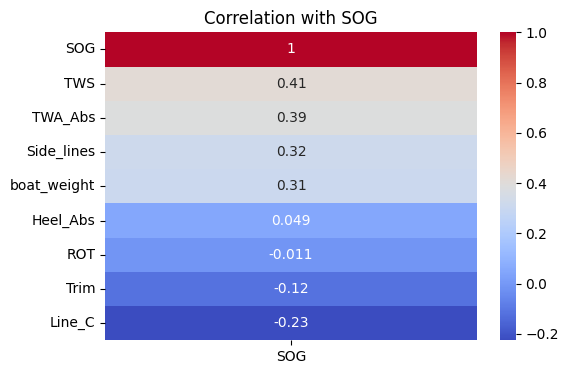


ANOVA:


,sum_sq,df,F,PR(>F)
TWA_Abs,2362.835887,1.0,2277.291269,0.000000e+00
TWS,2144.063121,1.0,2066.438999,0.000000e+00
boat_weight,1157.202724,1.0,1115.307108,7.339410e-235
Side_lines,365.823045,1.0,352.578709,1.181303e-77
Trim,312.228365,1.0,300.924382,1.128092e-66
Heel_Abs,298.219683,1.0,287.422874,8.514473e-64
Line_C,99.923742,1.0,96.306082,1.175780e-22
ROT,56.229097,1.0,54.193367,1.924139e-13
Residual,13745.650484,13248.0,NaN,NaN



Polynomial fit:
R²: 0.454
Used samples: 13257

 Formula :
SOG ≈ 26.717 +
  0.197 * Heel_Abs +
  0.261 * Line_C +
  -0.067 * ROT +
  0.510 * Side_lines +
  -0.187 * Trim +
  0.482 * TWA_Abs +
  0.457 * TWS +
  0.341 * boat_weight


,feature,coefficient
3,Side_lines,0.509877
5,TWA_Abs,0.482087
6,TWS,0.457265
7,boat_weight,0.341257
1,Line_C,0.261127
0,Heel_Abs,0.196741
4,Trim,-0.187261
2,ROT,-0.067364


In [24]:
full_analysis(df_numeric_master_downwind)

#### III.3.2 Downwind Slave

In [25]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 15674



Correlation with SOG:


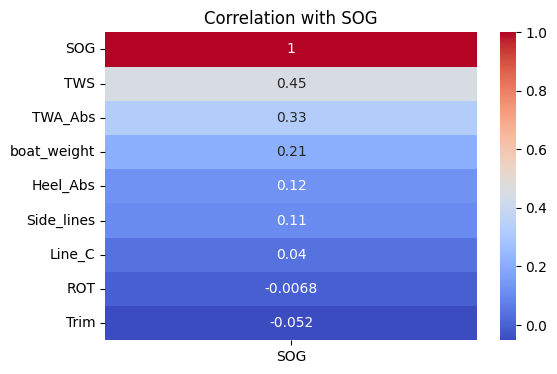


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,2001.787136,1.0,1570.935319,0.000000e+00
Line_C,1710.777747,1.0,1342.560924,2.234909e-280
Side_lines,1229.019369,1.0,964.493127,1.228113e-204
TWA_Abs,1110.253835,1.0,871.289924,1.168319e-185
boat_weight,406.244473,1.0,318.807020,1.681831e-70
Heel_Abs,185.597675,1.0,145.650823,2.292808e-33
Trim,58.789791,1.0,46.136254,1.148986e-11
ROT,18.088455,1.0,14.195212,1.654857e-04
Residual,17307.060674,13582.0,NaN,NaN



Polynomial fit:
R²: 0.347
Used samples: 13591

 Formula :
SOG ≈ 26.780 +
  0.156 * Heel_Abs +
  0.882 * Line_C +
  -0.038 * ROT +
  0.730 * Side_lines +
  -0.079 * Trim +
  0.363 * TWA_Abs +
  0.477 * TWS +
  0.201 * boat_weight


,feature,coefficient
1,Line_C,0.881849
3,Side_lines,0.729890
6,TWS,0.477071
5,TWA_Abs,0.363128
7,boat_weight,0.201399
0,Heel_Abs,0.155912
4,Trim,-0.078922
2,ROT,-0.037738


In [26]:
full_analysis(df_numeric_slave_downwind)

#### III.3.3. Downwind: Master vs Slave t_test

In [27]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: 0.953, p-value: 0.340575073568009
The difference is not statistically significant, keeping data combined.
